In [1]:
import cv2
import skimage as ski
from skimage.transform import radon

from scipy import ndimage

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# https://gist.github.com/endolith/334196bac1cac45a4893

import scipy.signal as signal
from scipy.signal import find_peaks

from scipy.optimize import curve_fit
from scipy.special import erf

import easyocr as ocr

In [2]:
# Constant variables mainly for the scale bar and number, SCALE_BAR_START and SCALE_BAR_END are
# a bit of gueswork just to limit the process time, but should always work.
SCALE_IMG_DIMENSIONS = 125
SCALE_BAR_START = 200
SCALE_BAR_END = 1250

def crop_image(img:np.ndarray, top_margin:int, bottom_margin:int, left_margin:int, right_margin:int) -> np.ndarray:
    width, height = img.shape
    return img[top_margin:height-bottom_margin, left_margin:width-right_margin]

def img2bin(im_gray, thresh):
    return cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]

def get_angle(img):
    sinogram = radon(img)
    rms_vals = np.array([np.sqrt(np.mean(np.abs(line) ** 2)) for line in sinogram.transpose()])
    angle = np.argmax(rms_vals)
    return -angle

def get_test_img():
    blank = np.zeros((100,100))
    blank = cv2.line(blank, (25,25), (75,75), (255, 255, 255), thickness=1)
    return blank

def normalize(values: np.ndarray) -> np.ndarray:
    min_value = min(values)
    max_value = max(values)
    normalize_values = (values - min_value) / (max_value - min_value)
    return normalize_values

def get_str_from_img(image: np.array):
    # Gets images and extracts text, jeej

    reader = ocr.Reader(['en'], gpu=True)
    # We use detail = 0 to just get the text, we dont care for the other info
    text_str = reader.readtext(image, detail = 0)
    return text_str

def get_scale_bar_size(image: np.array) -> int:
    scale_img = image[0 : image.shape[0], SCALE_BAR_START:SCALE_BAR_END]

    edges = cv2.Canny(scale_img, 50, 150, apertureSize = 3)
    lines = cv2.HoughLinesP(
                edges, # Input edge image
                1, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=100, # Min number of votes for valid line
                minLineLength=5, # Min allowed length of line
                maxLineGap=10 # Max allowed gap between line for joining them
    )

    return int(lines[0][0][2] - lines[0][0][0])

def get_scale(img, return_all = False, return_pm = False):
    height, width = img.shape
    info = img[height - 125 : height, 0:width]
    
    
    # How big of a 'cut-out' do we make from the left corner in the up and right  direction
    SCALE_IMG_DIMENSIONS = 95

    scale_img = info[0:img.shape[0], 0: SCALE_IMG_DIMENSIONS]
    scale_str = get_str_from_img(scale_img)[0]
    scale_int = int(scale_str)

    scale = scale_int / get_scale_bar_size(info)

    print(f'bar:{get_scale_bar_size(info)}')

    pm = (scale_int / (get_scale_bar_size(info) - 1)) - scale

    if return_all:
        return scale_str, scale_int, scale
    elif return_pm:
        return scale, pm

    return scale

(-0.5, 1797.5, 1622.5, -0.5)

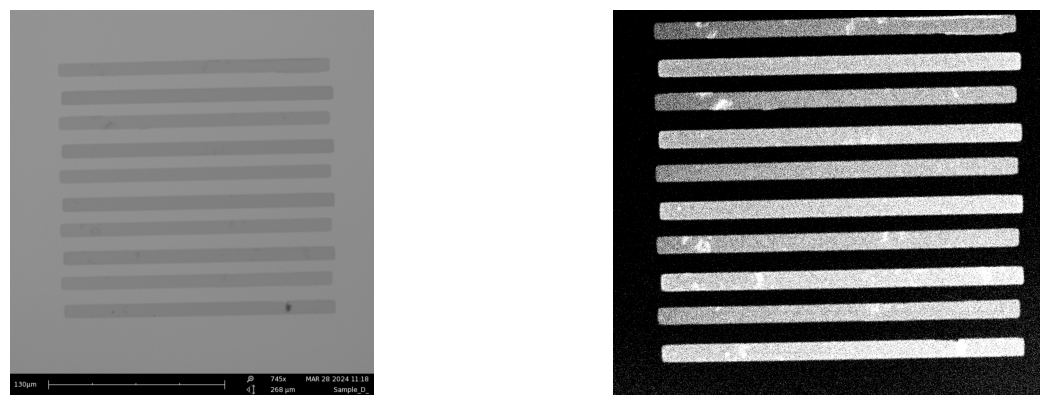

In [93]:
filename = 'Sample_D_0008.jpg'

original = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
original = original - np.mean(original)
crop = crop_image(original, 250, 175, 100, 270)

img = img2bin(crop, 0)

fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].imshow(original, 'gray')
ax[0].axis('off')
ax[1].imshow(img, 'binary')
ax[1].axis('off')

-91


(-0.5, 1515.5, 477.5, -0.5)

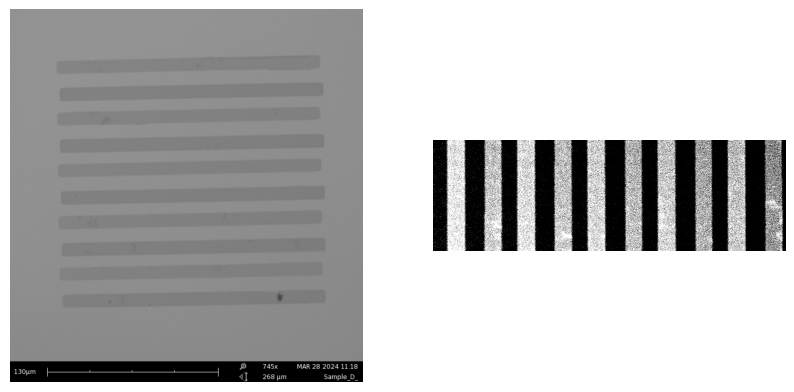

In [94]:
angle = get_angle(img)
img = ndimage.rotate(original, angle)
img = img2bin(img, 0)
img = crop_image(img, 850, 875, 400, 170)

print(angle)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(original, 'gray')
ax[0].axis('off')
ax[1].imshow(img, 'binary')
ax[1].axis('off')

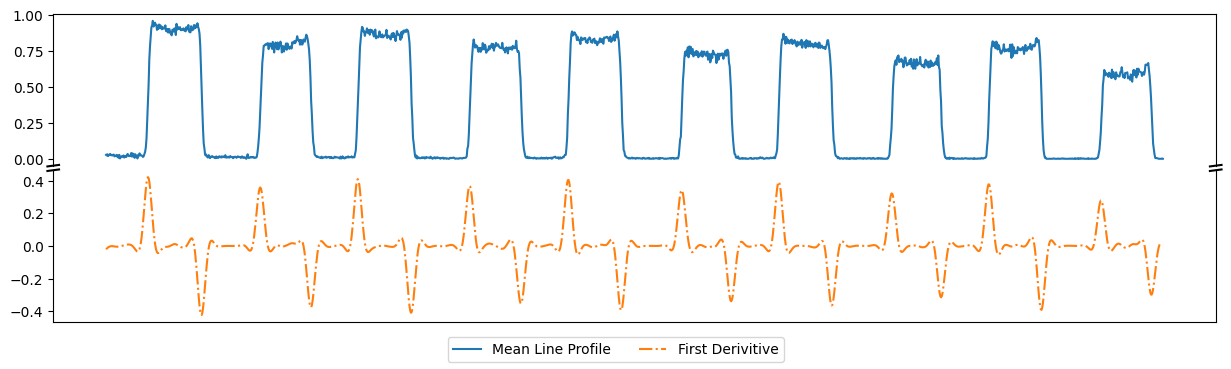

In [98]:

from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import erf

def error_function(x: np.ndarray, amplitude, x_offset, sigma, y_offset) -> np.array:
    diff = x - x_offset
    erf_term = erf(diff / (sigma * np.sqrt(2)))
    y = amplitude * 0.5 * (1 + erf_term) + y_offset
    return np.array(y)

def get_line_profile(img:np.ndarray, row:int):
    return 1-normalize(img[row, :])

def get_line_profile_dy(data:np.ndarray, scale_factor:int = 5):
    return np.diff(data * scale_factor)

def filter_data(data:np.ndarray, filter_order:int = 3, cutoff_freq:float = 0.1):
    # https://stackoverflow.com/questions/35588782/how-to-average-a-signal-to-remove-noise-with-python
    B, A = signal.butter(filter_order, cutoff_freq, output='ba')
    return signal.filtfilt(B, A, data)

# Define the Gaussian function
def gaussian_function(x, a, b, c):
    return a * np.exp(-((x - b) / c)**2)



scale = 130/1022
scale_pm = (130 / (1022 - 1)) - scale

y,x = img.shape

rp_list = np.empty(y, dtype=object)
for row in range(y):
    rp = get_line_profile(img, row)
    rp_list[row] = rp
mean_data = np.average(rp_list)    

dy = filter_data(get_line_profile_dy(mean_data))

peaks, _ = find_peaks(dy, height=0.1)
valleys, _ = find_peaks(-dy, height=0.1)



# fig, ax = plt.subplots(2,figsize = (15, 5))
# ax[0].plot(mean_data)
# ax[0].plot(dy)
# ax[0].plot(peaks, dy[peaks], "x")
# ax[0].plot(valleys, dy[valleys], "o")
# ax[1].imshow(img[:300,0:], 'binary')

fig,(ax,ax2) = plt.subplots(2, 1,figsize = (15, 4), sharex=True)
ax.plot(mean_data, color = 'C0',label='Mean Line Profile')
ax2.plot(dy, color = 'C1', linestyle='-.',label='First Derivitive')


# for idx in range(len(peaks)):
#     ax.axvline(peaks[idx], color='k',linestyle='--')
#     ax2.axvline(peaks[idx], color='k',linestyle='--')
#     ax.axvline(valleys[idx], color='k',linestyle='--')
#     ax2.axvline(valleys[idx], color='k',linestyle='--')


ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax2.spines['top'].set_visible(False)
plt.subplots_adjust(hspace=0.03)
d = .005 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-right diagonal
ax.plot((-d,d),(-d,d), **kwargs) # top-left diagonal

kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal
ax2.plot((-d,d),(1-d,1+d), **kwargs) # bottom-left diagonal

fig.legend(ncol=2,loc='lower center')

/var/folders/gz/fqw19gsd1zz83wptbmtl22780000gn/T/ipykernel_76467/2799805984.py:12: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(sum(w))*scale


Get mean line width: d = (9.79 ± 0.40) µm
Get mean line width: d = (9.29 ± 0.47) µm
Get mean line width: d = (9.67 ± 0.43) µm
Get mean line width: d = (9.41 ± 0.49) µm
Get mean line width: d = (9.54 ± 0.46) µm
Get mean line width: d = (9.03 ± 0.50) µm
Get mean line width: d = (9.67 ± 0.47) µm
Get mean line width: d = (9.03 ± 0.51) µm
Get mean line width: d = (9.67 ± 0.49) µm
Get mean line width: d = (9.29 ± 0.52) µm


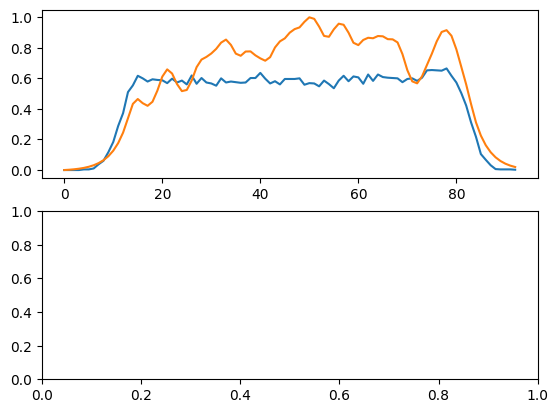

In [99]:
for idx in range(len(peaks)):
    line_width = (valleys[idx] - peaks[idx])*scale
    img_slice = img[:,peaks[idx]-10:valleys[idx]+10]
    data_slice = mean_data[peaks[idx]-10:valleys[idx]+10]
    y,x = img_slice.shape

    divs=np.array([])
    for row in range(y):
        row_profile = get_line_profile(img_slice, row)
        
        w = data_slice-filter_data(row_profile, 1, 0.1)**2
        err = np.sqrt(sum(w))*scale
        divs = np.append(divs, err)

    #https://stackoverflow.com/questions/11620914/how-do-i-remove-nan-values-from-a-numpy-array
    divs = divs[~np.isnan(divs)]
    err = np.mean(divs)  
    print(f'Get mean line width: d = ({line_width:.2f} ± {err:.2f}) µm')
    
fig, ax = plt.subplots(2)

ax[0].plot(data_slice)
ax[0].plot(get_line_profile(filter_data(img_slice, 1, 0.1), 100))
#ax.imshow(img_slice, 'binary')

#0.5296311445312716

In [97]:

T1 = (peaks[2] - valleys[1]) - (peaks[1] - valleys[0])
T2 = (peaks[4] - valleys[3]) - (peaks[3] - valleys[2])
T3 = (peaks[6] - valleys[5]) - (peaks[5] - valleys[4])
T4 = (peaks[8] - valleys[7]) - (peaks[7] - valleys[6])

print(np.mean([T1, T2, T3, T4])*scale, np.std([T1, T2, T3, T4])*scale)

-1.8835616438356164 0.12033633929793389
